In [1]:
import os
import cv2
import math
import torch
import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageFile
import matplotlib.pyplot as plt

# Allows PIL to load truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Appearance parameters for cv2 rectangles
thickness = 4

dim = 640
buff = 0.25
dim = 640
bdim = int( dim - (buff * 640) )
#thresh = 0.5

colorspace = [(55, 131, 255), (77, 233, 76), (255, 140, 0), (255, 238, 0), (246, 0, 0), (0, 0, 0)]

# Load yolo segmentation model and KLD inference model
seg = torch.hub.load('ultralytics/yolov5', 'custom', path='static/models/best_yolo.pt') # NEW VERSION TRAINED ON AL-ALL

%matplotlib inline

C:\Users\matth\anaconda3\envs\testenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in C:\Users\matth/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-5-16 Python-3.7.16 torch-1.13.1+cpu CPU

Fusing layers... 


requirements: C:\Users\matth\anaconda3\envs\testenv\Lib\site-packages\requirements.txt not found, check failed.


Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [22]:
# Function uses yolo model to find characters in image of papyrus fragments
def Segment(img_path):
    im = cv2.imread(img_path)[..., ::-1]
    #im = Image.open(img_path)#[..., ::-1]
    results = seg(im, size=640)
    df = results.pandas().xyxy[0]
    df.rename(columns = {'confidence':'yolo_confidence'}, inplace = True)
    #print(df)
    return df

def Iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def Convolve(path):
    tim = cv2.imread(path)[..., ::-1]
    h, w, c = tim.shape
    xconvs = math.ceil(w / bdim)
    yconvs = math.ceil(h / bdim)
    L = []
    R = []
    T = []
    B = []
    C = []
    cc = []
    subs = []

    cs = 0
    for j in range(yconvs):
        btm = j * 480
        top = btm + 640
        if top >= h:
            top = h - 1
        if cs >= 4:
            cs = 0
        cs += 1
        #print(btm,top, "**********")
        for j in range(xconvs):
            left = j * 480
            right = left + 640
            if right >= w:
                right = w - 1
            if cs >= 4:
                cs = 0
            col = colorspace[cs]
            cs += 1
            crop = tim[btm:top, left:right]
            subs.append([(left, btm), (right, top)])
            dat = seg(crop, size=640)
            df = dat.pandas().xyxy[0]
            df.rename(columns = {'confidence':'yolo_confidence'}, inplace = True)
            xmin = list(df.xmin)
            xmax = list(df.xmax)
            ymin = list(df.ymin)
            ymax = list(df.ymax)
            conf = list(df['yolo_confidence'])
            for k in range(len(xmin)):
                L.append(xmin[k] + left)
                R.append(xmax[k] + left)
                B.append(ymin[k] + btm)
                T.append(ymax[k] + btm)
                C.append(conf[k])
                cc.append(col)
    return  L, R, T, B, C, cc, subs, tim

def Display(L, R, T, B, C, cc, subs, tim):
    imgc = tim.copy()

    for i in range(len(L)):
        sp = (int(L[i]), int(B[i]))
        ep = (int(R[i]), int(T[i]))
        imgc = cv2.rectangle(imgc, sp, ep, cc[i], thickness)
    imgrgb = cv2.cvtColor(imgc, cv2.COLOR_BGR2RGB)
    cv2.imwrite("transcribed.jpg", imgrgb)  
    plt.figure()
    plt.imshow(imgc)
    #plt.savefig('yolo_out.png')
    plt.show()
    
def Pairs(L, R, T, B, thr):
    matches = []
    pairs = []
    for j in range(len(L)):
        for i in range(len(L)):
            if i != j:
                ival1 = Iou([L[j], B[j], R[j], T[j]], [L[i], B[i], T[i], R[i]])
                ival2 = Iou([L[i], B[i], R[i], T[i]], [L[j], B[j], T[j], R[j]])                                    
                if ival1 > thr:
                    matches.append((j, i))
                if ival2 > thr:
                    matches.append((j, i))

    matches = list(set(matches))
    for k in range(len(matches)):
        t = matches[k]
        t0 = t[0]
        t1 = t[1]
        target = (t1, t0)
        if target in matches:
            matches[k] = False

    for l in range(len(matches)):
        if matches[l] != False:
            pairs.append(matches[l])
    return pairs

In [18]:
#L, R, T, B, C, cc, subs, tim = Convolve("testimg.jpg")
L, R, T, B, C, cc, subs, tim = Convolve("graham_test.jpg")
res = Pairs(L, R, T, B, 0.5)
print(res)

[(3934, 4188), (2724, 3231), (4188, 3877), (3934, 4174), (2699, 2664), (3877, 4174), (4188, 4174), (3934, 3877), (596, 657), (12, 0), (6, 1), (3292, 3842), (645, 660), (2616, 2668), (2716, 2663), (645, 567)]


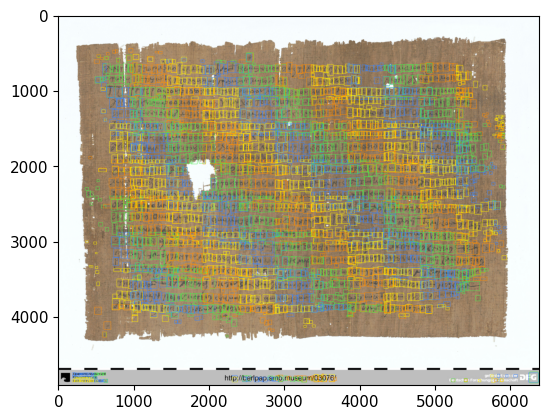

In [23]:
Display(L, R, T, B, C, cc, subs, tim)